# Predict monthly energy usage of smart refrigerators 
## Data
* Three customer's data from January to April is provided
* If the refrigerator is getting data, every 15 seconds the following data is obtained:
* Compressor: active(1) or off(0)
* Temp: the refrigerator temperature
* Door: open(1) or closed(0)
* roomTemp: room temperature
* setpoint: the set temperature of the refrigerator

## Compressor and energy consumption
* When the compressor is off, there is no energy consumption
* When the compressor is active, it consumes 0.2 kW

## To predict
* Three customers usage in May at three different setpoints

## 1. Import library, build functions and import the data

In [32]:
import gzip
import json_lines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir, scandir
import numpy as np
from sklearn.preprocessing import MinMaxScaler
plt.rcParams["figure.figsize"] = (20,10)
sns.set()

In [10]:
# read one file
def read_one_file(filename):
    data=[]
    for item in json_lines.reader(gzip.open(filename)):
        data.append(item)
    df = pd.DataFrame.from_dict(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp',inplace=True)
    return df

# plot the gap between timestamps
def plot_gap(df):
    df_gap = df.reset_index()
    df_gap['gap'] = df_gap['timestamp'].diff()
    df_gap['gap'] = df_gap['gap'].apply(lambda x: x.total_seconds())
    df_gap.set_index('timestamp', inplace=True)
    plt.plot(df_gap.index, df_gap.gap)

# delay the compressor a little bit to see what lag may correlate with the door the best
def test_corr(df):
    df2 = df.copy()
    for i in range(1,7):
        df2['c'+str(i)] = df.compressor.shift(-i)
    return(df2.corr())

# Average data into a single day, and plot all the data by time (scaled all the data to 0-1)
def plot_day_pattern(df):
    scaler = MinMaxScaler()
    by_time = df.groupby(df.index.time).mean()
    hourly_ticks = 4 * 60 * 60 * np.arange(6)
    by_time[by_time.columns] = scaler.fit_transform(by_time[by_time.columns])
    by_time.plot(xticks= hourly_ticks)

In [3]:
# get the customer ID: CID
CID = []
MID = [1,2,3,4]
for filename in listdir('take_home_data_challenge/' + str(MID[0])):
    CID.append(filename.split('.')[0])
CID

['de58b445-cfe9-4d0d-adae-5bef928a9dd0',
 '8b916a17-57b0-4449-bcaf-8f2d16c00bf7',
 '09ac4a10-7e8e-40f3-a327-1f93a5cf2383']

In [4]:
# read all the files
df = []
for customer in CID:
    for month in MID:
        filename = 'take_home_data_challenge/' + str(month) + '/' + customer + '.jsonl.gz'
        print(filename)
        df.append(read_one_file(filename))

take_home_data_challenge/1/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
take_home_data_challenge/2/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
take_home_data_challenge/3/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
take_home_data_challenge/4/de58b445-cfe9-4d0d-adae-5bef928a9dd0.jsonl.gz
take_home_data_challenge/1/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
take_home_data_challenge/2/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
take_home_data_challenge/3/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
take_home_data_challenge/4/8b916a17-57b0-4449-bcaf-8f2d16c00bf7.jsonl.gz
take_home_data_challenge/1/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
take_home_data_challenge/2/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
take_home_data_challenge/3/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz
take_home_data_challenge/4/09ac4a10-7e8e-40f3-a327-1f93a5cf2383.jsonl.gz


In [11]:
# merge files for the same customer together in order
df1 = pd.concat([df[0], df[1], df[2], df[3]])
df2 = pd.concat([df[4], df[5], df[6], df[7]])
df3 = pd.concat([df[8], df[9], df[10], df[11]])

In [6]:
df1.head()

,compressor,temp,door,roomTemp,setpoint
timestamp,,,,,
2019-01-01 00:00:00+00:00,0.0,43.0,0.0,57.878680,43.0
2019-01-01 00:00:15+00:00,0.0,43.0,0.0,57.876367,43.0
2019-01-01 00:00:30+00:00,0.0,43.0,0.0,57.874057,43.0
2019-01-01 00:00:45+00:00,0.0,43.0,0.0,57.871749,43.0
2019-01-01 00:01:00+00:00,0.0,43.0,0.0,57.869444,43.0


## 2. study the gap between time stamps
### Observations:
* time gap for customer 1 can be as long as 8000 seconds, which is a little over 2 hours
* customer 2 has perfect data every 15 seconds
* customer 3 has 4 large period of time with no data

### Assumption:
* For customer 1, assume the missing data would follow the mean of the available data

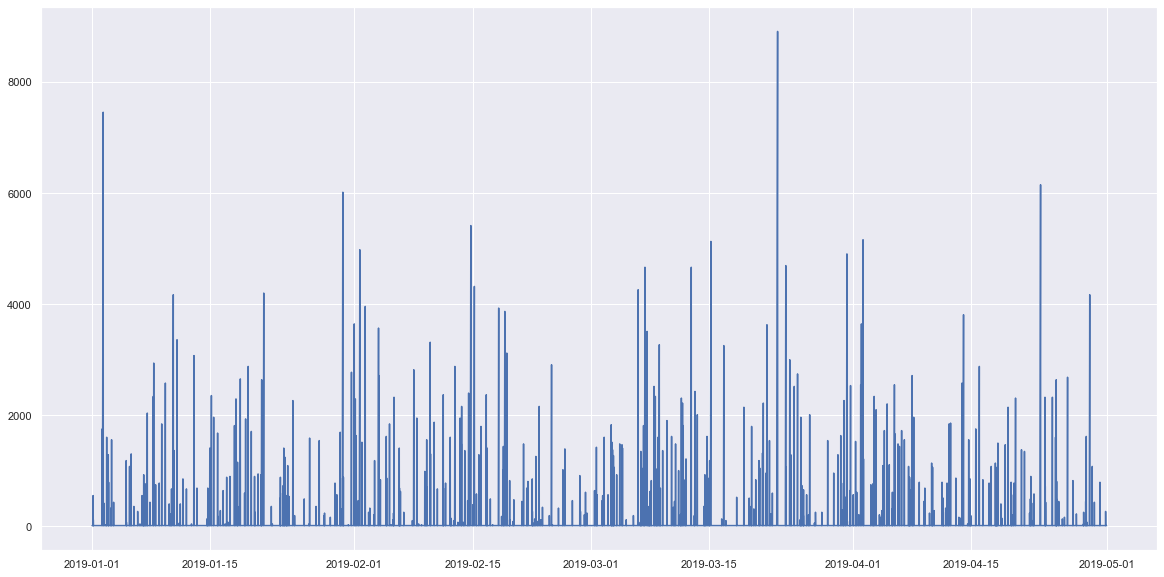

In [33]:
# time gap for customer 1 can be as long as 8000 seconds, which is a little over 2 hours
plot_gap(df1)

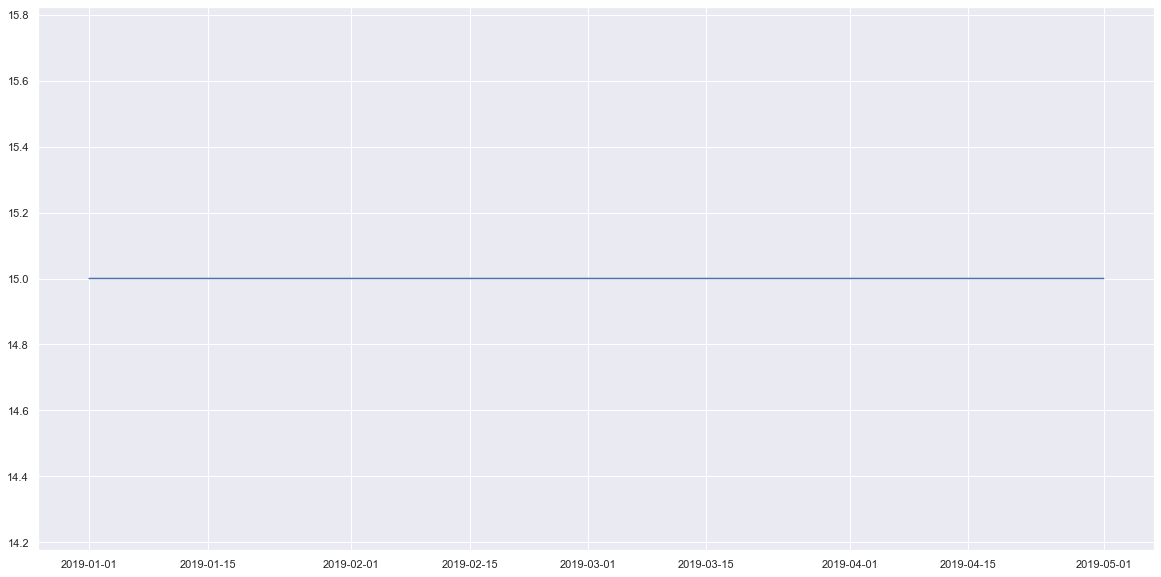

In [34]:
# customer 2 has perfect data.
plot_gap(df2)

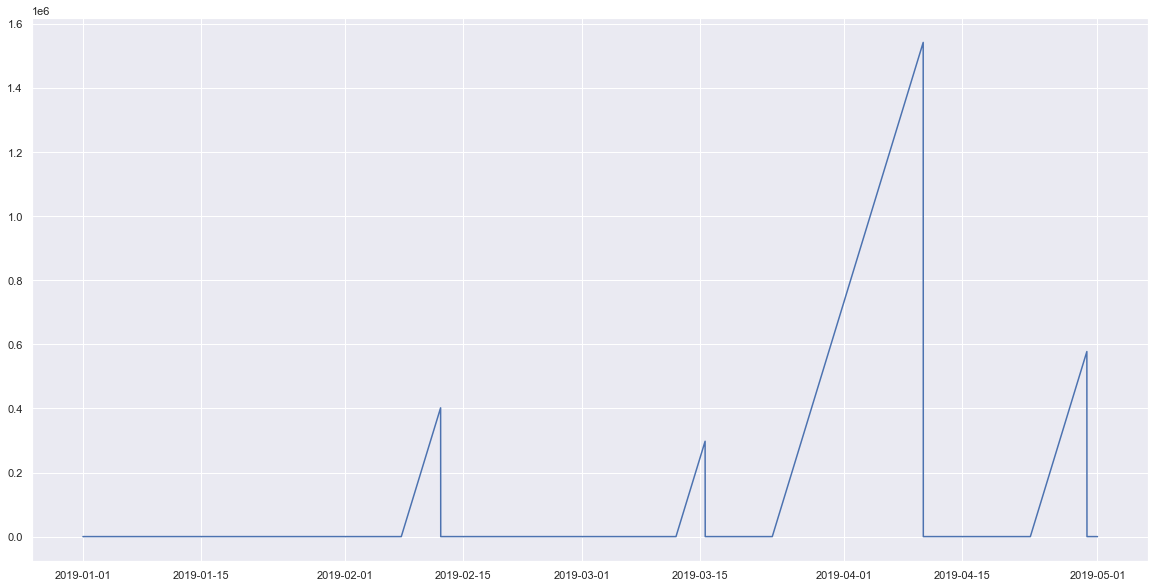

In [35]:
# customer 3 has 4 large period of time with no data
plot_gap(df3)

## 3. Study the compressor pattern across time

<BarContainer object of 120 artists>

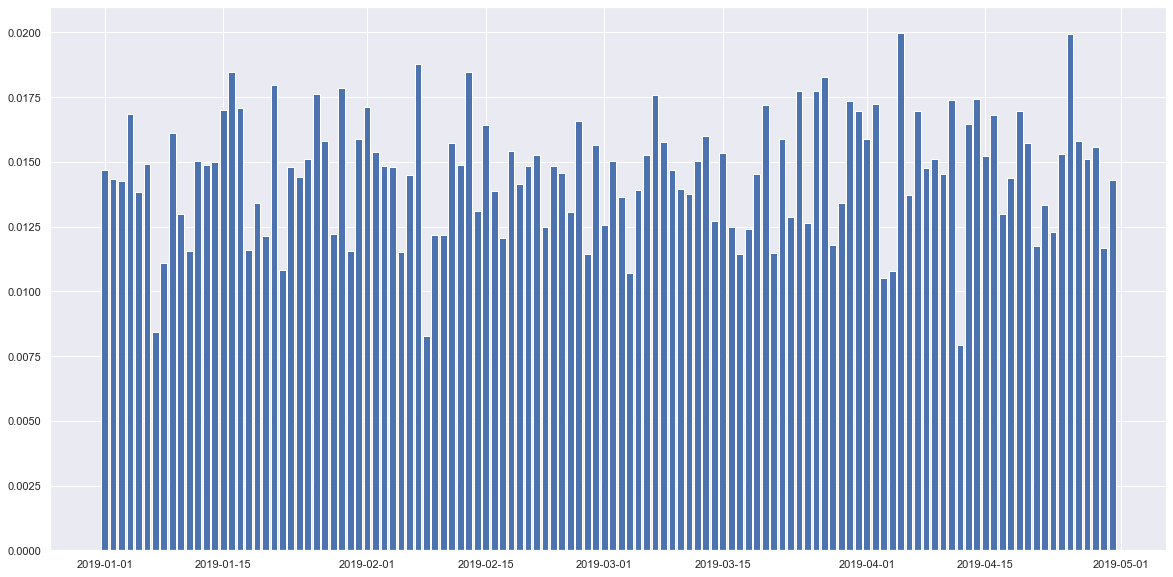

In [36]:
df_day = df1.resample('D').mean()
plt.bar(df_day.index, df_day.compressor)

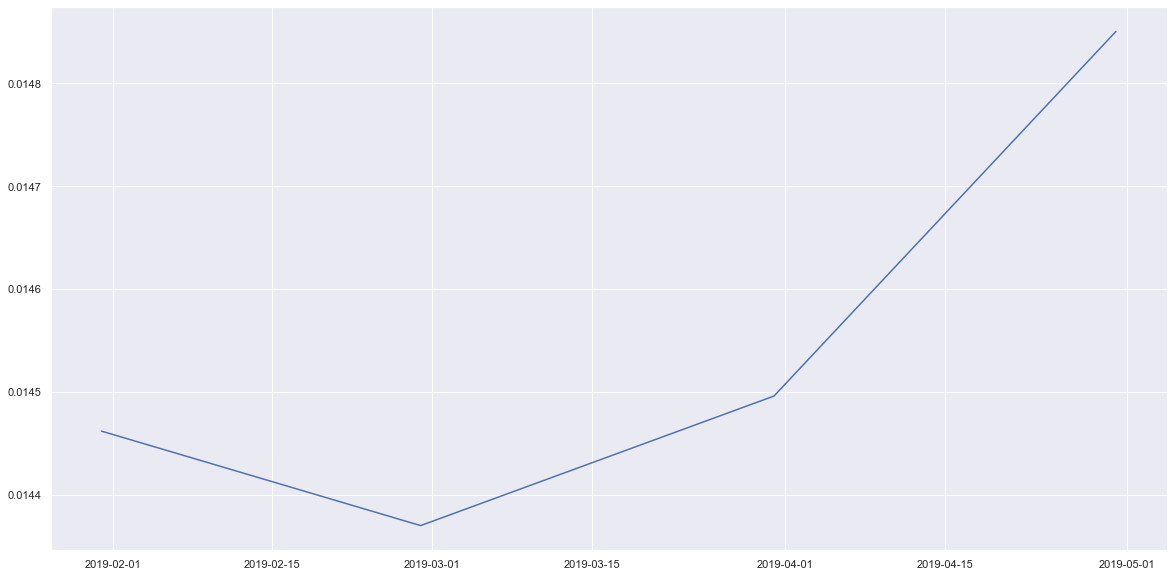

In [37]:
df_M = df1.resample('M').mean()
plt.plot(df_M.index, df_M.compressor)

<BarContainer object of 120 artists>

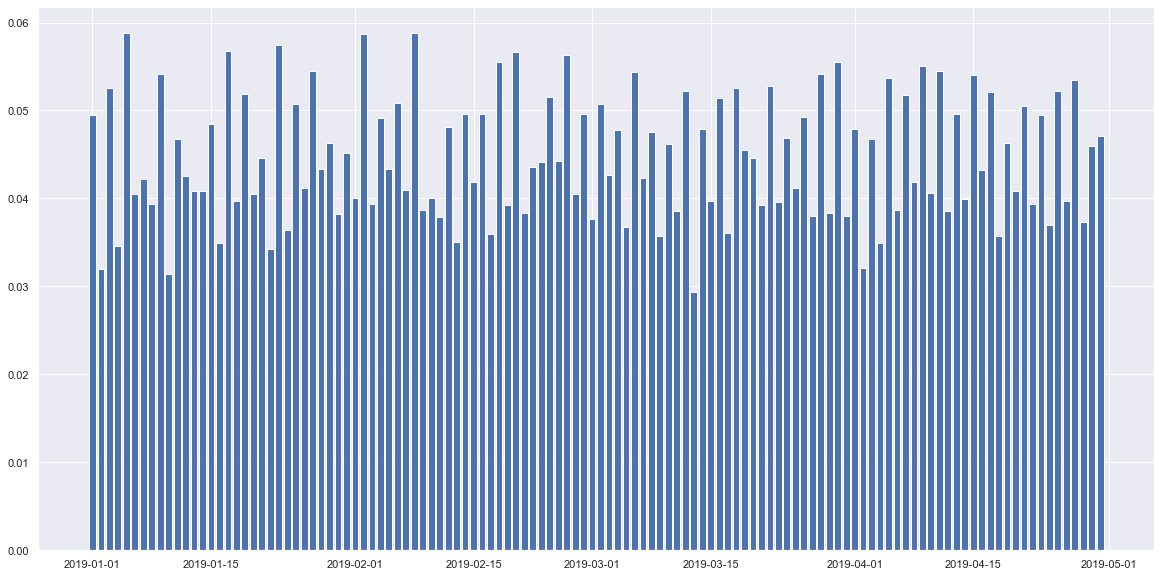

In [38]:
df_day = df2.resample('D').mean()
plt.bar(df_day.index, df_day.compressor)

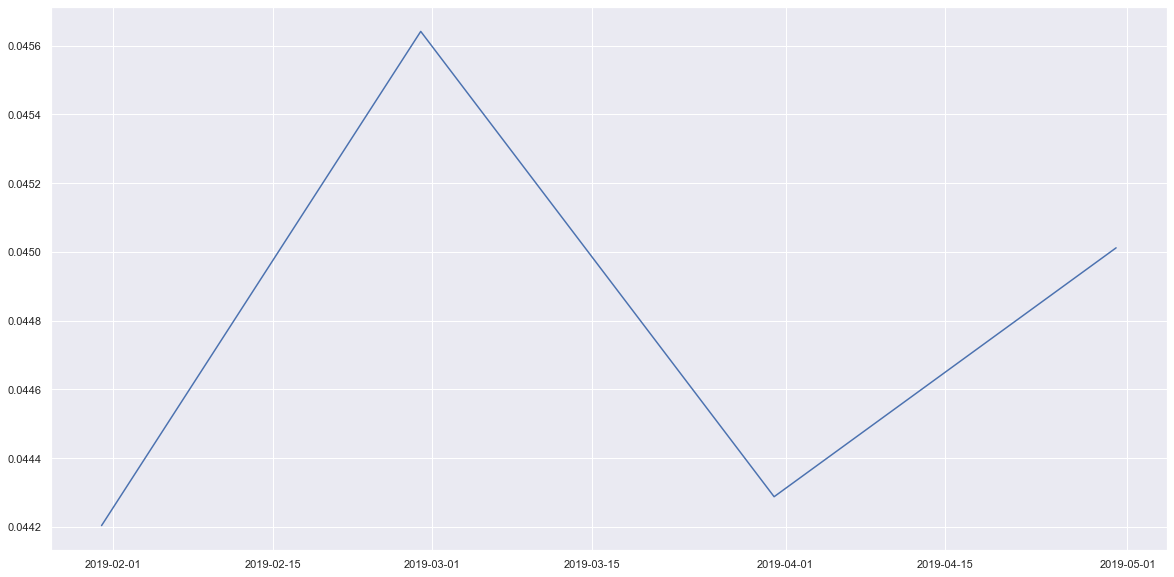

In [39]:
df_M = df2.resample('M').mean()
plt.plot(df_M.index, df_M.compressor)

<BarContainer object of 120 artists>

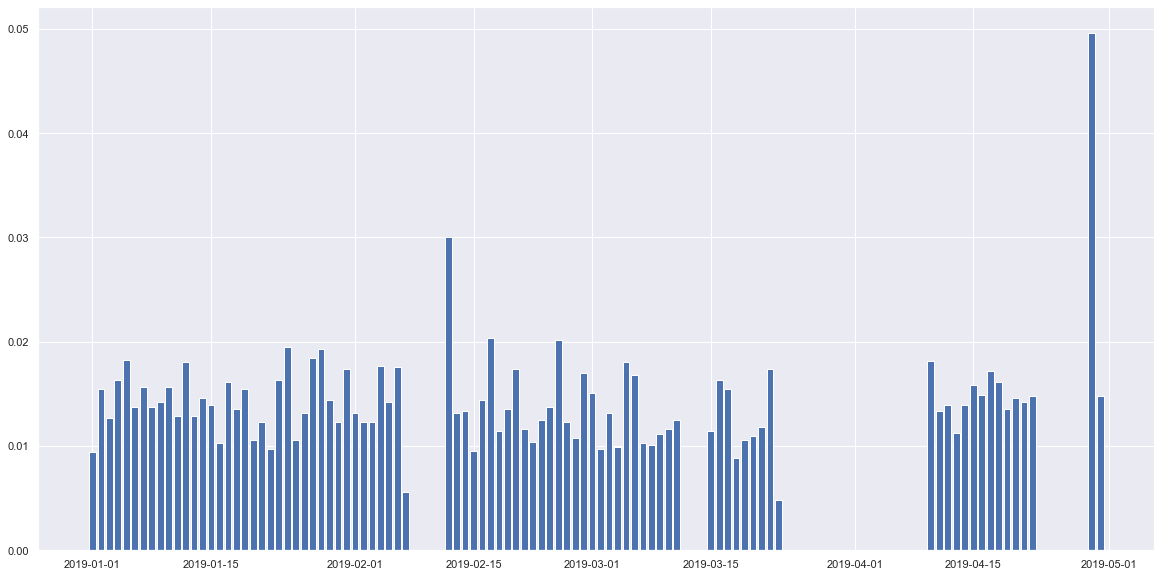

In [40]:
df_day = df3.resample('D').mean()
plt.bar(df_day.index, df_day.compressor)

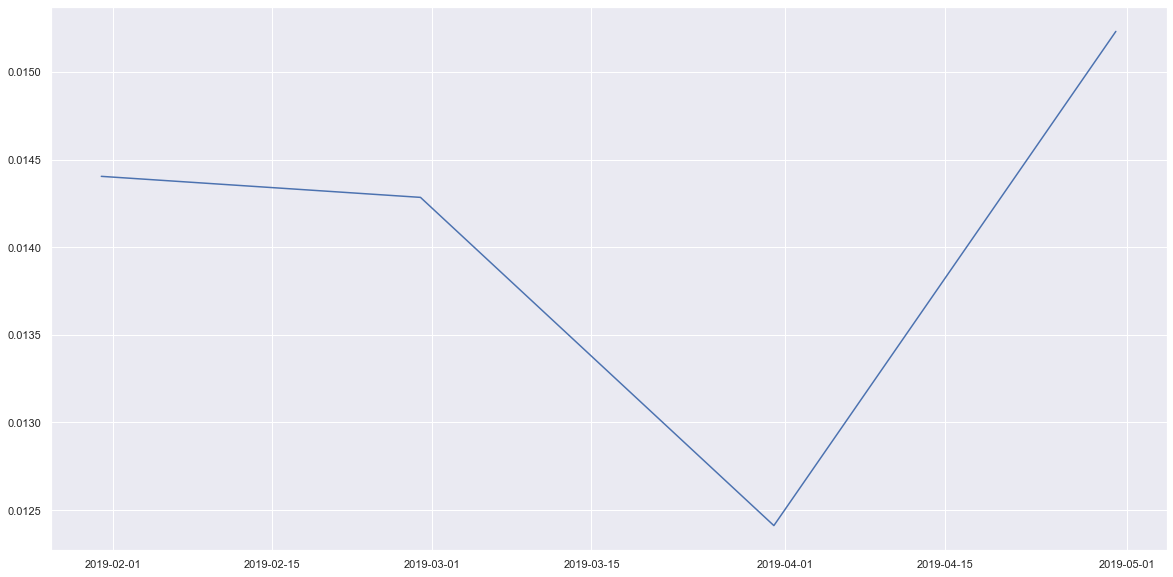

In [41]:
df_M = df3.resample('M').mean()
plt.plot(df_M.index, df_M.compressor)

## 4. study the door pattern across time

<BarContainer object of 120 artists>

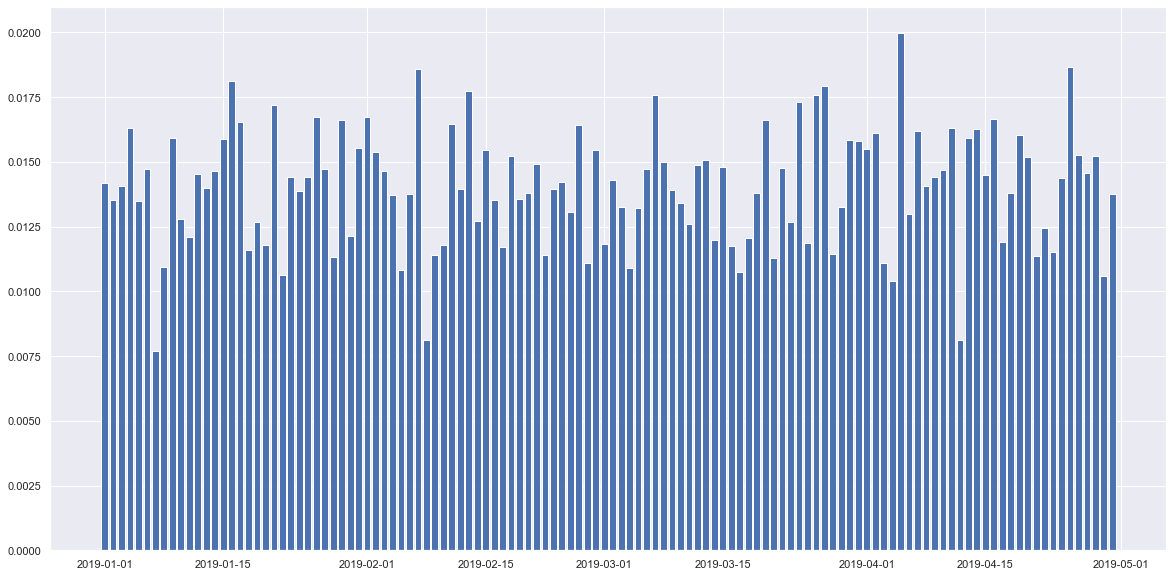

In [42]:
df_day = df1.resample('D').mean()
plt.bar(df_day.index, df_day.door)

<BarContainer object of 120 artists>

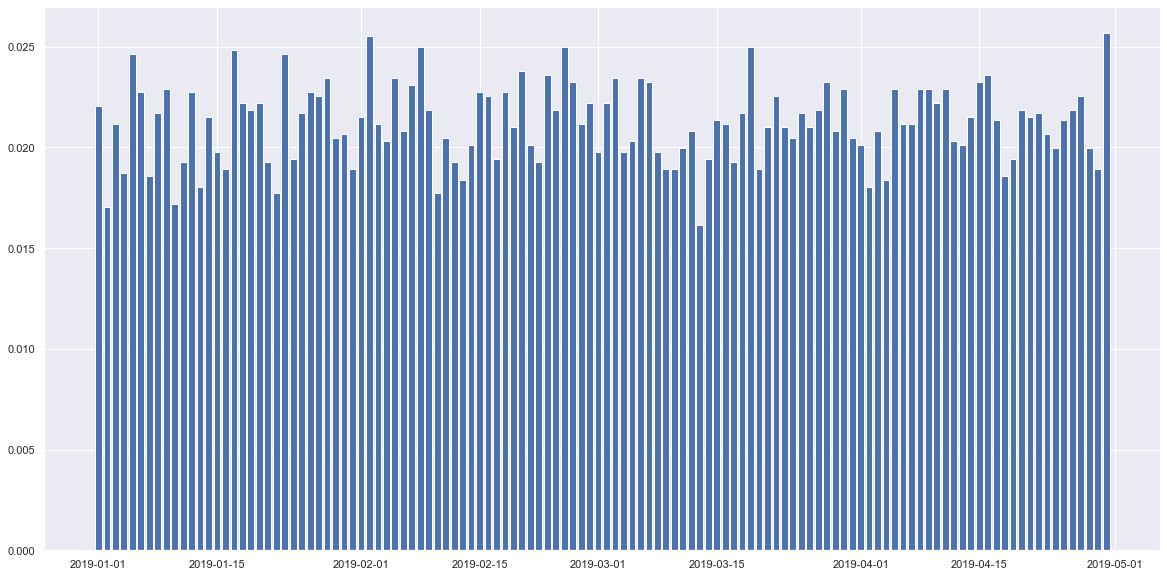

In [43]:
df_day = df2.resample('D').mean()
plt.bar(df_day.index, df_day.door)

<BarContainer object of 120 artists>

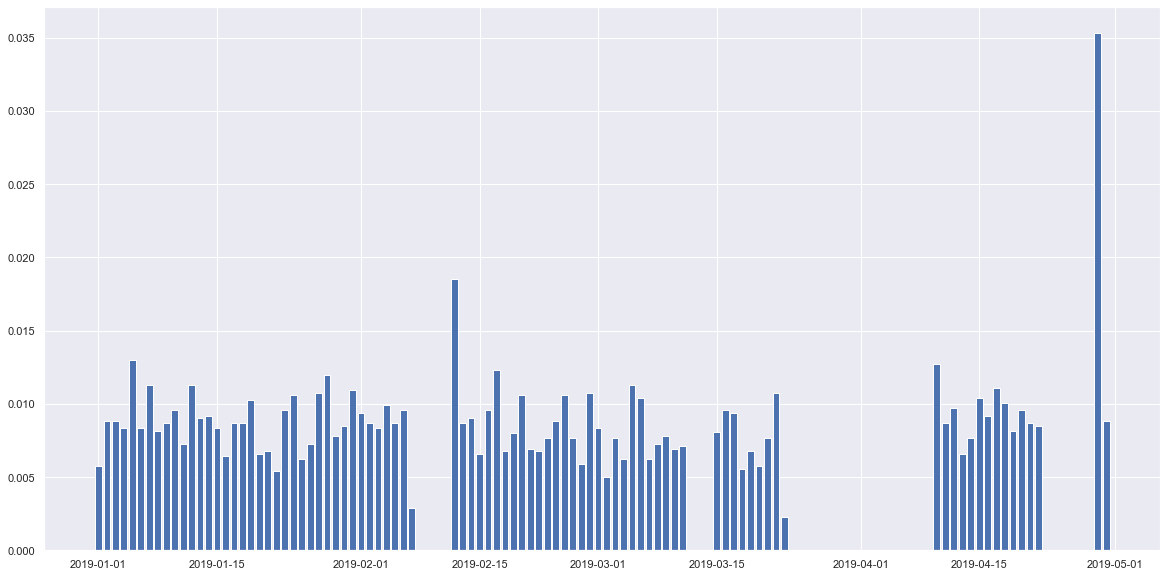

In [44]:
df_day = df3.resample('D').mean()
plt.bar(df_day.index, df_day.door)

## 5. Compressor and door looks correlated, test their correlation
### Observations:
* Temperature is highly correlated with compressor and door in customer 1 and 3
* For customer 1 door best correlated with c4, which means the lag is 4 x 15 seconds= 60, and it reached a correlation of 0.96
* For customer 2 due to other factors the correlation between compressor and door was not as good as customer 1, the best lag seems to be c6, but it could be outside of the range that was tested (lag = 1 to 6)
* For customer 3, from lag 3 and above the correlation between compressor and door stayed at 0.78.

In [45]:
# for customer 1 door best correlated with c4, which means the lag is 4 x 15 seconds= 60
test_corr(df1)

,compressor,temp,door,roomTemp,setpoint,c1,c2,c3,c4,c5,c6
compressor,1.000000,0.913718,0.732651,0.074388,NaN,0.939707,0.879520,0.819333,0.759253,0.699172,0.639198
temp,0.913718,1.000000,0.872496,0.081690,NaN,0.959664,0.973893,0.955619,0.904926,0.843838,0.780227
door,0.732651,0.872496,1.000000,0.069162,NaN,0.793295,0.853829,0.914039,0.969800,0.949405,0.898200
roomTemp,0.074388,0.081690,0.069162,1.000000,NaN,0.074381,0.074375,0.074369,0.074363,0.074356,0.074344
setpoint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,0.939707,0.959664,0.793295,0.074381,NaN,1.000000,0.939707,0.879520,0.819333,0.759253,0.699172
c2,0.879520,0.973893,0.853829,0.074375,NaN,0.939707,1.000000,0.939707,0.879520,0.819333,0.759253
c3,0.819333,0.955619,0.914039,0.074369,NaN,0.879520,0.939707,1.000000,0.939707,0.879520,0.819333
c4,0.759253,0.904926,0.969800,0.074363,NaN,0.819333,0.879520,0.939707,1.000000,0.939707,0.879520
c5,0.699172,0.843838,0.949405,0.074356,NaN,0.759253,0.819333,0.879520,0.939707,1.000000,0.939707


In [46]:
# for customer 2 due to other factors the correlation between compressor and door was not as good as customer 1, 
# the best lag seems to be c6, but it could be outside of the range that was tested (lag = 1 to 6)
test_corr(df2)

,compressor,temp,door,roomTemp,setpoint,c1,c2,c3,c4,c5,c6
compressor,1.000000,0.379285,0.553032,2.180645e-01,-2.825197e-02,0.958789,0.917578,0.876840,0.836373,0.796380,0.756691
temp,0.379285,1.000000,0.266055,2.596659e-01,6.279353e-01,0.383120,0.381693,0.378487,0.373569,0.366943,0.358615
door,0.553032,0.266055,1.000000,1.543420e-01,-1.013926e-03,0.609299,0.665566,0.669693,0.672606,0.675519,0.678432
roomTemp,0.218065,0.259666,0.154342,1.000000e+00,-7.168853e-16,0.218059,0.218053,0.218046,0.218040,0.218033,0.218026
setpoint,-0.028252,0.627935,-0.001014,-7.168853e-16,1.000000e+00,-0.027426,-0.026600,-0.025774,-0.024948,-0.024123,-0.023297
c1,0.958789,0.383120,0.609299,2.180587e-01,-2.742608e-02,1.000000,0.958789,0.917577,0.876840,0.836373,0.796380
c2,0.917578,0.381693,0.665566,2.180527e-01,-2.660020e-02,0.958789,1.000000,0.958789,0.917577,0.876840,0.836373
c3,0.876840,0.378487,0.669693,2.180464e-01,-2.577431e-02,0.917577,0.958789,1.000000,0.958789,0.917577,0.876840
c4,0.836373,0.373569,0.672606,2.180398e-01,-2.494843e-02,0.876840,0.917577,0.958789,1.000000,0.958789,0.917577
c5,0.796380,0.366943,0.675519,2.180330e-01,-2.412254e-02,0.836373,0.876840,0.917577,0.958789,1.000000,0.958789


In [47]:
# for customer 3, from c3 and above the correlation between compressor and door stayed at 0.78.
test_corr(df3)

,compressor,temp,door,roomTemp,setpoint,c1,c2,c3,c4,c5,c6
compressor,1.000000,0.869103,0.586117,-0.047872,NaN,0.940691,0.881382,0.822073,0.762907,0.703742,0.644719
temp,0.869103,1.000000,0.643829,-0.025378,NaN,0.889657,0.885334,0.863509,0.832933,0.793621,0.745575
door,0.586117,0.643829,1.000000,-0.051098,NaN,0.661505,0.736894,0.782418,0.782418,0.782418,0.782418
roomTemp,-0.047872,-0.025378,-0.051098,1.000000,NaN,-0.047788,-0.047705,-0.047621,-0.047537,-0.047454,-0.047370
setpoint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c1,0.940691,0.889657,0.661505,-0.047788,NaN,1.000000,0.940691,0.881382,0.822073,0.762907,0.703742
c2,0.881382,0.885334,0.736894,-0.047705,NaN,0.940691,1.000000,0.940691,0.881382,0.822073,0.762907
c3,0.822073,0.863509,0.782418,-0.047621,NaN,0.881382,0.940691,1.000000,0.940691,0.881382,0.822073
c4,0.762907,0.832933,0.782418,-0.047537,NaN,0.822073,0.881382,0.940691,1.000000,0.940691,0.881382
c5,0.703742,0.793621,0.782418,-0.047454,NaN,0.762907,0.822073,0.881382,0.940691,1.000000,0.940691


## 6. Study setpoint
### Observations
* Customer 1 and 3 had a single setpoint and it stays constent
* Costomer 2 has two setpoints, and they alternate once a day at the very first time stamp of the day

In [48]:
print(df1.setpoint.unique())
print(df2.setpoint.unique())
print(df3.setpoint.unique())

[43.]
[34. 42.]
[37.]


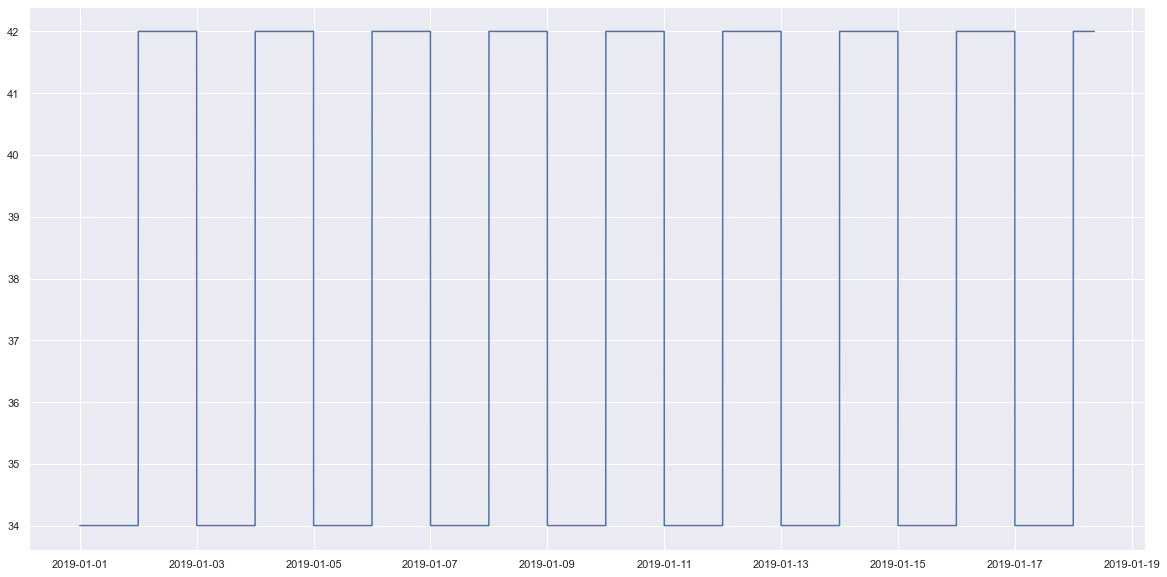

In [49]:
plt.plot(df2.index[0:100000], df2.setpoint[0:100000])

## 7. plot day pattern
### Observations:
* Room Temperature oscillate throughout the day but it follows the exact same pattern every day
* Compressor, temperature, door are highly connected to each other

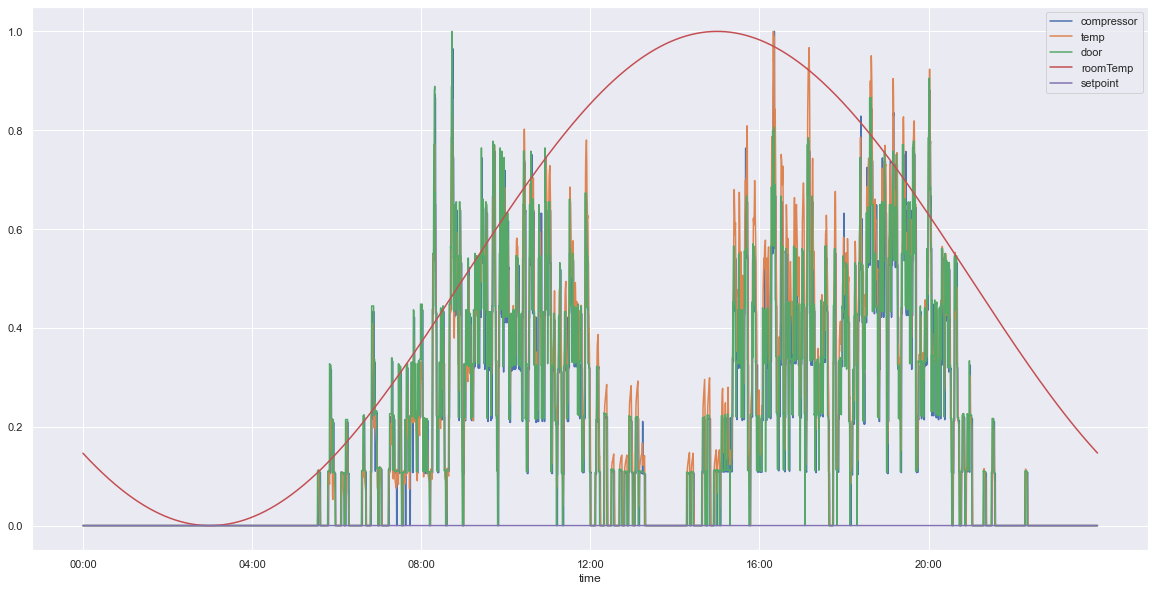

In [50]:
plot_day_pattern(df1)

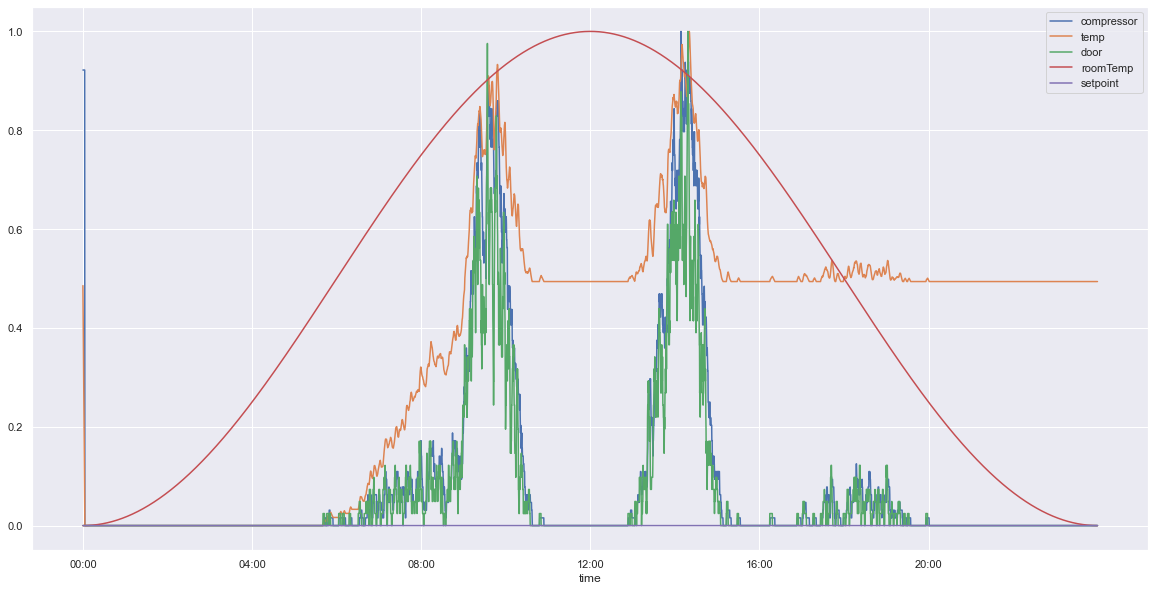

In [51]:
plot_day_pattern(df2)

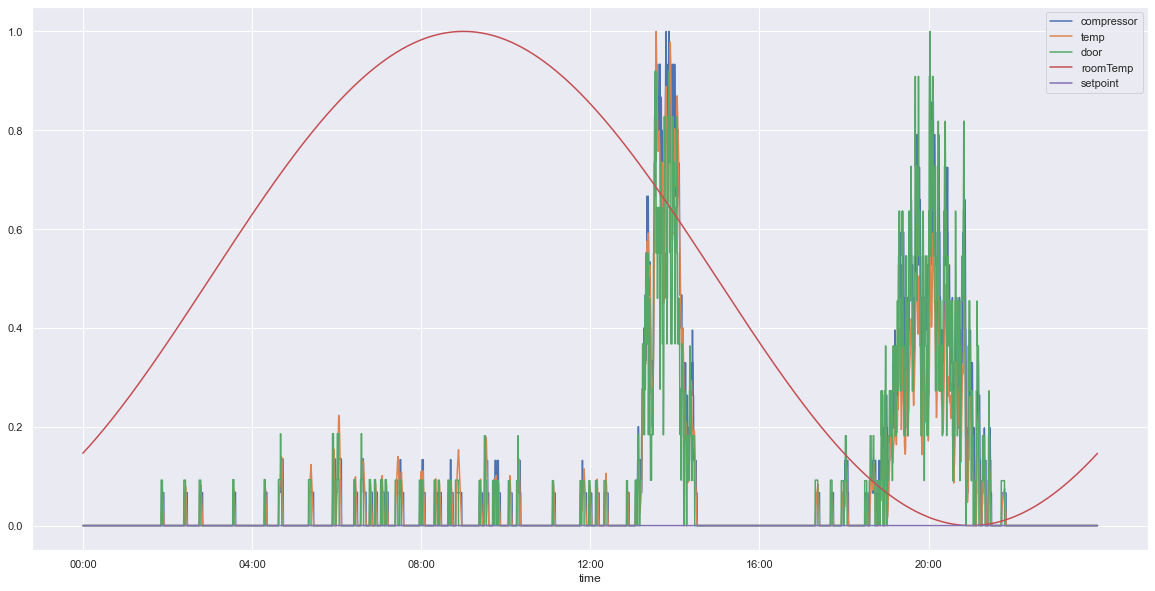

In [52]:
plot_day_pattern(df3)

## 8. study the missing data from customer 3
### Observation
* door opened for longer after every large period of missing data

### Conclusion
* Missing data in customer 3 means the refrigerator was turned off

<BarContainer object of 120 artists>

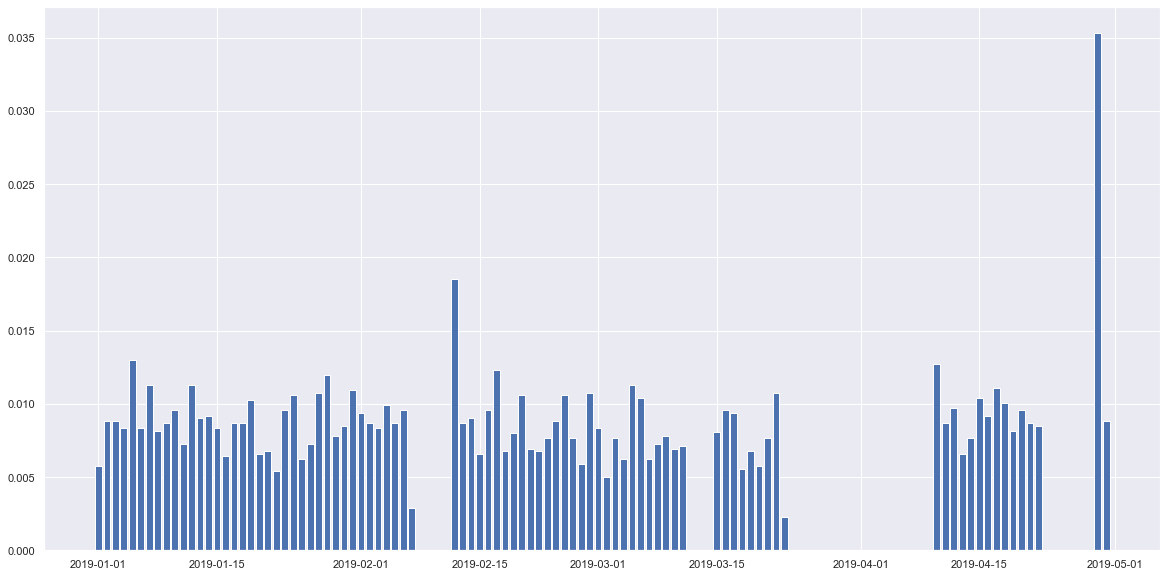

In [53]:
df_day = df3.resample('D').mean()
plt.bar(df_day.index, df_day.door)

## 9. Take a closer look

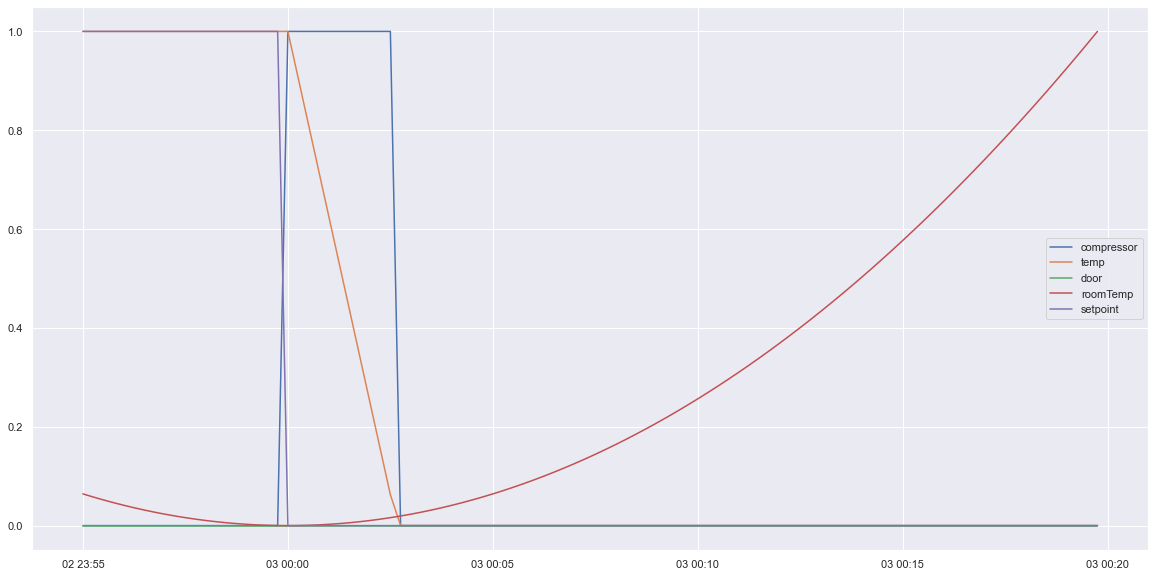

In [54]:
# setpoint change
scaler = MinMaxScaler()
plt.plot(df2.index[11500:11600], scaler.fit_transform(df2[11500:11600]))
plt.legend(df2.columns)

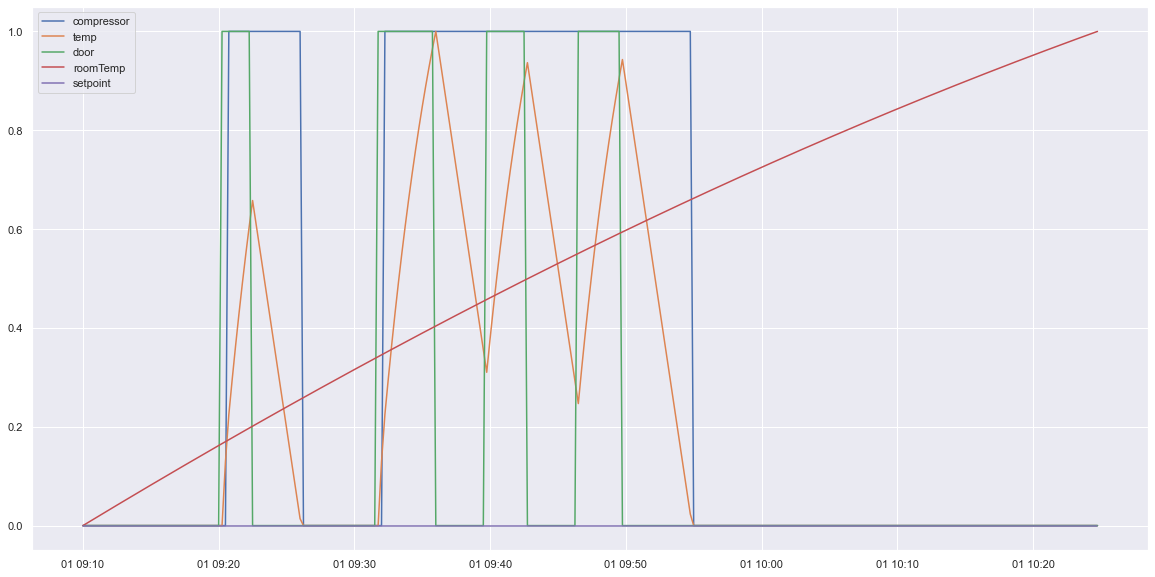

In [55]:
# door opening
scaler = MinMaxScaler()
plt.plot(df2.index[2200:2500], scaler.fit_transform(df2[2200:2500]))
plt.legend(df2.columns)

## 9 Conclusion from EDA:
* Customer 1 has one single setpoint, majority of the data, compressor is highly correlated with door (lag 60 seconds correlation 0.96)
* Customer resets setpoint at the beginning of each day, thus the compressor is influenced by both door and setpoint
* Customer 3 has one single setpoint, but large period of missing data, in which was speculated as refrigerator being turned off (vacant time), so the copressor is influenced by both door and vacant time